In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import tqdm

In [31]:
data_train = dset.SVHN('./data/', split='train', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])]))

Using downloaded and verified file: ./data/train_32x32.mat


In [32]:
data_test = dset.SVHN('./data/', split='test', download=True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Using downloaded and verified file: ./data/test_32x32.mat


In [0]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

In [0]:
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [35]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    reducer = 1    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if epoch%2==1:
            reducer*=2
            optimizer = optim.SGD(nn_model.parameters(), lr=(1e-3)/reducer, weight_decay=1e-1)
            print(reducer)
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    accuracy = []
    for batch in loader:
        accuracy.append(torch.mean((model(batch[0]).argmax(axis=1) == batch[1]).float()))
    accuracy = torch.mean(torch.Tensor(accuracy))
    
    return accuracy
    
    raise Exception("Not implemented")
    
    return 0

#loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

In [38]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.256162, Train accuracy: 0.185954, Val accuracy: 0.187825
2
Average loss: 2.245617, Train accuracy: 0.189554, Val accuracy: 0.187854
Average loss: 2.245667, Train accuracy: 0.189554, Val accuracy: 0.187825
4
Average loss: 2.245615, Train accuracy: 0.189554, Val accuracy: 0.187837
Average loss: 2.245606, Train accuracy: 0.189554, Val accuracy: 0.187854


In [39]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.086042, Train accuracy: 0.301488, Val accuracy: 0.420092
2
Average loss: 1.832191, Train accuracy: 0.450961, Val accuracy: 0.489467
Average loss: 1.731224, Train accuracy: 0.498498, Val accuracy: 0.526489
4
Average loss: 1.669788, Train accuracy: 0.527472, Val accuracy: 0.544518
Average loss: 1.636996, Train accuracy: 0.543153, Val accuracy: 0.563981


In [0]:

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = []
    ground_truth = []
    
    for index in indices:
        x, y = dataset[index]
        pred = model(x.reshape(1, 3, 32, 32)).argmax(axis=1)
        predictions.append(pred)
        ground_truth.append(y)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

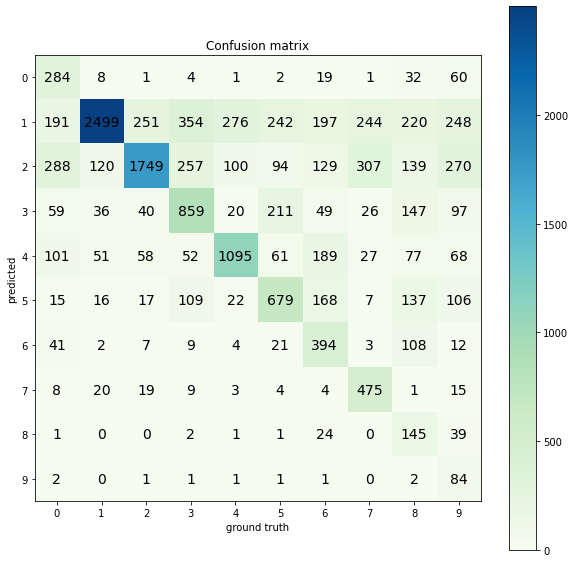

In [41]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for pred, gt in zip(predictions, ground_truth):
        confusion_matrix[pred, gt] += 1
    
    # TODO: Implement filling the prediction matrix
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

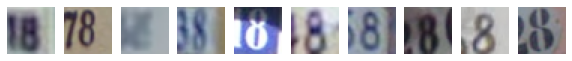

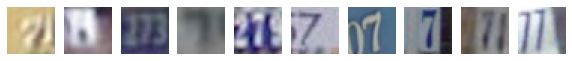

In [42]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    indices = []
     
    for num, (pred, gt) in enumerate(zip(predictions, groud_truth)):
        if pred == predicted_class and gt == gt_class:
            indices.append(val_indices[num])
            
    visualize_images(indices, data)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

In [0]:

Переходим к свободным упражнениям!
Натренируйте модель как можно лучше - экспериментируйте сами! Что следует обязательно попробовать:

перебор гиперпараметров с помощью валидационной выборки
другие оптимизаторы вместо SGD
изменение количества слоев и их размеров
наличие Batch Normalization
Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до 80%

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, scheduler=None, num_epochs=10, verbosity=0, scheduler_loss=False):        
    train_loss_history = []
    train_acc_history = []

    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        if verbosity >= 2:
            if epoch > 0:
                print('')
            
            print('Epoch #%s - optimizer state: %s' % (epoch, optimizer.state_dict()))
        
        loss_accum = 0.0
        correct_samples = 0.0
        total_samples = 0.0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += float(loss_value)

        train_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
                
        val_loss, val_accuracy = compute_loss_accuracy(model, val_loader)
        
        if scheduler is not None:
            if scheduler_loss:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)        
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        
        if verbosity >= 1:
            print("Epoch #%s - train loss: %f, accuracy: %f | val loss: %f, accuracy: %f" % (epoch, train_loss, train_accuracy, val_loss, val_accuracy))
        
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [0]:
def compute_loss_accuracy(model, loader):
    """
    Computes loss and accuracy on the dataset wrapped in a loader
    
    Returns: (average loss, accuracy as a float value between 0 and 1)
    """
    model.eval() # Evaluation mode
    
    loss_accum = 0.0
    correct = 0.0
    total = 0.0
    for i, (x, y) in enumerate(loader):
        y_probs = model(x)        
        y_hat = torch.argmax(y_probs, 1)
        
        loss_value = loss(y_probs, y)
        loss_accum += float(loss_value)
        
        correct += float(torch.sum(y_hat == y))
        total += y.shape[0]
        
    return loss_accum / (i + 1), correct / total

In [0]:
import math

batch_size = 64

layer1 = 100
layer2 = 100

learning_rate = 1e-3
reg_strength = 1e-4

epochs = 50

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, sampler=val_sampler)

nn_model = nn.Sequential(
    Flattener(),
    
    nn.Linear(3*32*32, layer1),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer1),
    
    nn.Linear(layer1, layer2),    
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(layer2),
    
    nn.Linear(layer2, 10)
)

In [59]:
nn_model.type(torch.FloatTensor)

optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=reg_strength)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.333, patience=3, verbose=True)
%time train_loss_hh, train_acc_hh, val_loss_hh, val_acc_hh = train_model(nn_model, train_loader, val_loader, loss, optimizer, scheduler, \
                                                                         num_epochs=epochs, verbosity=1, scheduler_loss=True)

Epoch #0 - train loss: 0.942169, accuracy: 0.703187 | val loss: 0.862397, accuracy: 0.730872
Epoch #1 - train loss: 0.820749, accuracy: 0.742433 | val loss: 0.815657, accuracy: 0.748959
Epoch #2 - train loss: 0.757074, accuracy: 0.763915 | val loss: 0.726826, accuracy: 0.780015
Epoch #3 - train loss: 0.702489, accuracy: 0.780534 | val loss: 0.686646, accuracy: 0.794417
Epoch #4 - train loss: 0.671892, accuracy: 0.791301 | val loss: 0.650393, accuracy: 0.801857
Epoch #5 - train loss: 0.643222, accuracy: 0.798451 | val loss: 0.702598, accuracy: 0.788615
Epoch #6 - train loss: 0.621156, accuracy: 0.805634 | val loss: 0.661180, accuracy: 0.797898
Epoch #7 - train loss: 0.609048, accuracy: 0.809764 | val loss: 0.625374, accuracy: 0.811753
Epoch #8 - train loss: 0.599311, accuracy: 0.811862 | val loss: 0.637263, accuracy: 0.806430
Epoch #9 - train loss: 0.583329, accuracy: 0.818005 | val loss: 0.609008, accuracy: 0.817965
Epoch #10 - train loss: 0.574485, accuracy: 0.820206 | val loss: 0.610

In [60]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_loss, test_accuracy = compute_loss_accuracy(nn_model, test_loader)
print("Test loss: %f, accuracy: %f" % (test_loss, test_accuracy))

Test loss: 0.629807, accuracy: 0.826329
